In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data import generate_data_second_order 
from models import GibbsSamplerLLFM
from evals import latent_features, latent_features_dominant_to_file
import matplotlib.pyplot as plt


In [2]:
#Parameters
K=10            
alpha=0.7
sigma_w=3.0
sigma_b=1
#bias=[-5, -5, -5, -5]
mu_b = -1.5 #if sampling
n_iter=5000
burn=1000
n_subsample=1000
ax_values = [0, 5, 10, 40, 60]
#ax_values = [0, 2, 4, 6, 8, 10, 15, 20, 30, 40, 50, 60]
#ax_values = [a for a in range(0, 61, 3)]
conds_list = [[1,0,0], [0,1,0], [0,0,1], [0,1,1]]
n_z_samples = 100
print(ax_values)

[0, 5, 10, 40, 60]


In [3]:
posterior_probs_all = {str(conds): [] for conds in conds_list}
avg_features_list = []
dominant_features_list = []
for axnum in ax_values:

    # Generate dataset
    Data = generate_data_second_order(axnum=axnum)
    
    # Run Gibbs sampler
    sampler = GibbsSamplerLLFM(Data, K=K, n_iter=n_iter, alpha=alpha, sigma_w=sigma_w, mu_b=mu_b, sigma_b=sigma_b, burn=burn, n_subsample=n_subsample)
    sampler.run(verbose=False)
    sampler.get_posterior_samples()
    
    avg_features = latent_features(threshold=5, Z_post=sampler.good_samples_Z, W_post=sampler.good_samples_W, b_post=sampler.good_samples_b)
    avg_features_list.append(avg_features)
    dominant_features = latent_features_dominant_to_file('latent_features_dominant2.txt', threshold=5, Z_post=sampler.good_samples_Z, W_post=sampler.good_samples_W, b_post=sampler.good_samples_b, header=f'Number of A-X pairs: {axnum}.\n\n')
    dominant_features_list.append(dominant_features)

    # ---- Posterior predictive probabilities ----
    for conds in conds_list:
        p_y3 = sampler.posterior_predictive(
            cond_obs=conds, n_z_samples=n_z_samples
        )
        posterior_probs_all[str(conds)].append(p_y3)

Posterior grouping by number of active features

Number of samples with zero active features: 0/1000

Group with 2 active features:
  Number of posterior samples: 374/1000
  Average usage per feature (size-biased order):
[106.57486631  60.65508021]
  Average weights:
[[  1.96765388 -22.28993662  -3.80930209   4.54426585]
 [ -0.72034551 -11.03546866   0.13845053   1.89526848]]
  Average Bias:
[-0.08207938 -1.47306843 -0.19251677 -0.0610344 ]
--------------------------------------------------
Group with 3 active features:
  Number of posterior samples: 468/1000
  Average usage per feature (size-biased order):
[106.51923077  72.03418803  24.11538462]
  Average weights:
[[  2.6280659  -20.24013507  -4.09673258   4.35371372]
 [  1.6615331  -12.11279002  -2.38361112   2.17073826]
 [ -2.90692984  -4.03894462   3.45039195   1.03582896]]
  Average Bias:
[-0.12144054 -1.38590759 -0.18895607 -0.07919705]
--------------------------------------------------
Group with 4 active features:
  Number of 

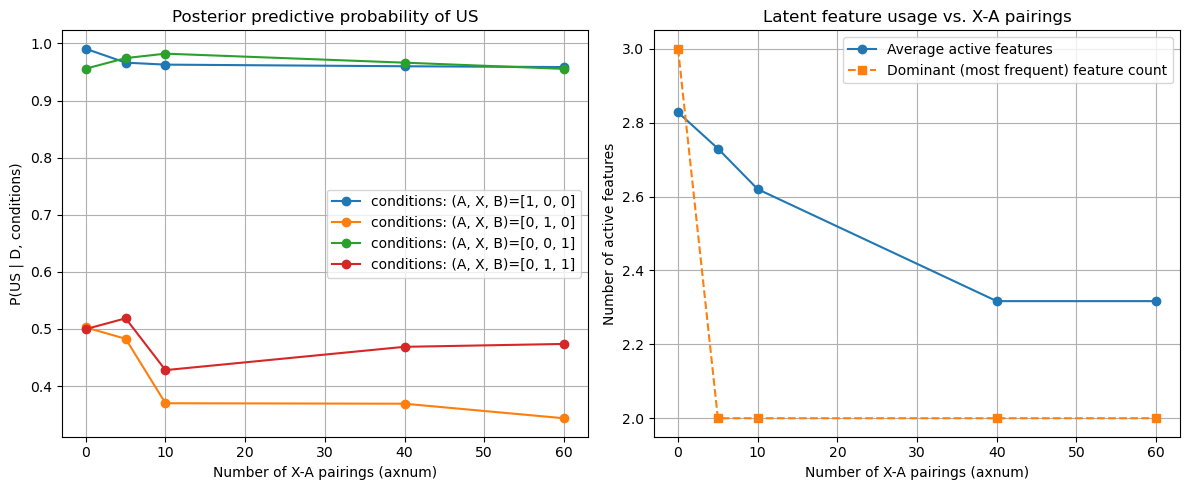

In [4]:
# ------------------------------
# Plot results
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# ------------------------------
# Posterior predictive probabilities
# ------------------------------
for conds in conds_list:
    axes[0].plot(
        ax_values,
        posterior_probs_all[str(conds)],
        marker='o',
        label=f'conditions: (A, X, B)={conds}'
    )

axes[0].set_xlabel("Number of X-A pairings (axnum)")
axes[0].set_ylabel("P(US | D, conditions)")
axes[0].set_title("Posterior predictive probability of US")
axes[0].grid(True)
axes[0].legend()


# ------------------------------
# Latent feature statistics
# ------------------------------
axes[1].plot(
    ax_values,
    avg_features_list,
    marker='o',
    label="Average active features"
)

axes[1].plot(
    ax_values,
    dominant_features_list,
    marker='s',
    linestyle='--',
    label="Dominant (most frequent) feature count"
)

axes[1].set_xlabel("Number of X-A pairings (axnum)")
axes[1].set_ylabel("Number of active features")
axes[1].set_title("Latent feature usage vs. X-A pairings")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
#plt.savefig("posterior_predictive_and_features.png", dpi=300)
plt.show()
